In [3]:
import os
import re
import string

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
from torchtext import data
from torch import nn
import torch.nn.functional as F
import copy
import torch.optim as optim
import time
# import evaluate

In [4]:
##定义读取训练数据和测试数据的函数
def load_text_data(path):
    ##获取文件夹的最后一个字段
    text_data = []
    label = []
    for dset in ["pos", "neg"]:
        path_dset = os.path.join(path, dset)
        path_list = os.listdir(path_dset)
        ##读取文件夹下的pos或neg文件
        for fname in path_list:
            if fname.endswith(".txt"):
                filename = os.path.join(path_dset, fname)
                ##打开文件时指定编码，忽略位置编码
                with open(filename, encoding='gbk', errors="ignore") as f:
                    text_data.append(f.read())
            if dset == "pos":
                label.append(1)
            else:
                label.append(0)
    ##输出读取的文本和对应的标签
    return np.array(text_data), np.array(label)


##读取训练集和测试集
train_path = "data/aclImdb/train"
train_text, train_label = load_text_data(train_path)
test_path = "data/aclImdb/test"
test_text, test_label = load_text_data(test_path)


In [5]:
print(len(train_text), len(train_label))
print(len(test_text), len(test_label))

25000 25000
25000 25000


In [6]:
##对文本数据进行预处理
def text_preprocess(text_data):
    text_pre = []
    for text1 in text_data:
        ##去除指定的字符“<br /><br />”
        text1 = re.sub("<br /><br />", " ", text1)
        ##转化为小写，去除数字，去除标点符号，去除空格
        text1 = text1.lower()
        text1 = re.sub("\d+", "", text1)
        text1 = text1.translate(
            str.maketrans("", "", string.punctuation.replace("'", "")))
        text1 = text1.strip()
        text_pre.append(text1)
    return np.array(text_pre)


train_text_pre = text_preprocess(train_text)
test_text_pre = text_preprocess(test_text)



In [7]:
##文本符号化处理，去除停用词
def stop_stem_word(datalist, stop_words):
    datalist_pre = []
    for text in datalist:
        text_words = word_tokenize(text)
        ##去停用词
        text_words = [word for word in text_words if not word in stop_words]
        ##删除带有“‘”的词语，如it's
        text_words = [word for word in text_words if len(re.findall("'", word)) == 0]
        datalist_pre.append(text_words)
    print(len(datalist_pre))
    ##这里指定数据类型
    return np.array(datalist_pre, dtype=object)


##文本符号化，去停用词
stop_words = stopwords.words("english")
stop_words = set(stop_words)
train_text_pre2 = stop_stem_word(train_text_pre, stop_words)
test_text_pre2 = stop_stem_word(test_text_pre, stop_words)
print(train_text_pre[1:10])
print("=" * 10)
print(train_text_pre2[1:10])

25000
25000
["homelessness or houselessness as george carlin stated has been an issue for years but never a plan to help those on the street that were once considered human who did everything from going to school work or vote for the matter most people think of the homeless as just a lost cause while worrying about things such as racism the war on iraq pressuring kids to succeed technology the elections inflation or worrying if they'll be next to end up on the streets but what if you were given a bet to live on the streets for a month without the luxuries you once had from a home the entertainment sets a bathroom pictures on the wall a computer and everything you once treasure to see what it's like to be homeless that is goddard bolt's lesson mel brooks who directs who stars as bolt plays a rich man who has everything in the world until deciding to make a bet with a sissy rival jeffery tambor to see if he can live in the streets for thirty days without the luxuries if bolt succeeds he 

In [8]:
##将处理好的文本保存到CSV文件中
texts = [" ".join(words) for words in train_text_pre2]
traindatasave = pd.DataFrame({"text": texts,
                              "label": train_label})
texts = [" ".join(words) for words in test_text_pre2]
testdatasave = pd.DataFrame({"text": texts,
                             "label": test_label})
traindatasave.to_csv("data\imdb_train.csv", index=False)
testdatasave.to_csv("data\imdb_test.csv", index=False)

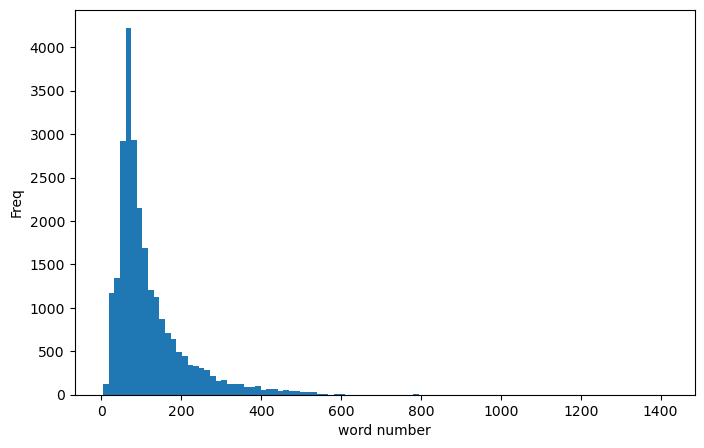

In [9]:
##将预处理好的文本数据转化为数据表
traindata = pd.DataFrame({"train_text": train_text, "train_word": train_text_pre2, "train_label": train_label})
##计算每个影评使用的词数量
train_word_num = [len(text) for text in train_text_pre2]
traindata["train_word_num"] = train_word_num
##可视化每个影评词语长度的分布
plt.figure(figsize=(8, 5))
_ = plt.hist(train_word_num, bins=100)
plt.xlabel("word number")
plt.ylabel("Freq")
plt.show()

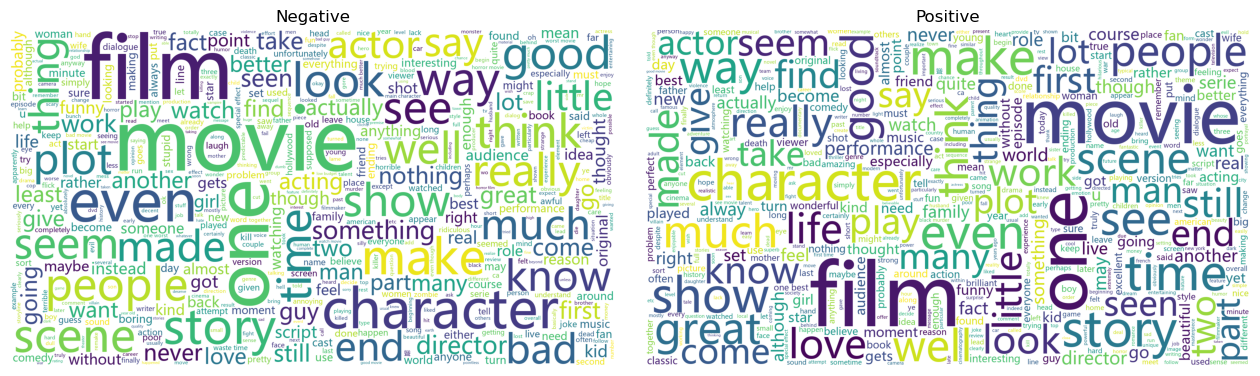

In [10]:
##使用词云可视化两种情感的词频差异
plt.figure(figsize=(16, 10))
for ii in np.unique(train_label):
    ##准备每种情感的所有词语
    text = np.array(traindata.train_word[traindata.train_label == ii])
    text = " ".join(np.concatenate(text))
    plt.subplot(1, 2, ii + 1)
    ##生成词云
    wordcod = WordCloud(margin=5, width=1800, height=1000, max_words=500,
                        min_font_size=5, background_color='white', max_font_size=250)
    wordcod.generate_from_text(text)
    plt.imshow(wordcod)
    plt.axis("off")
    if ii == 1:
        plt.title("Positive")
    else:
        plt.title("Negative")
    plt.subplots_adjust(wspace=0.05)
plt.show()

In [11]:
##使用torchtext库进行数据准备，定义文件中对文本和标签所要做的操作
##定义文本切分方法，因为前面已经做过处理，所以直接使用空格切分即可
mytokenize = lambda x: x.split()
TEXT = data.Field(sequential=True, tokenize=mytokenize, include_lengths=True, use_vocab=True, batch_first=True,
                  fix_length=200)
LABEL = data.Field(sequential=False, use_vocab=False, pad_token=None, unk_token=None)
train_test_files = [
    ("text", TEXT),  ##对文本的操作
    ("label", LABEL)  ##对标签的操作
]
##对所要读取的数据集的列进行处理
##读取数据
traindata, testdata = data.TabularDataset.splits(
    path="./data", format="csv",
    train="imdb_train.csv", fields=train_test_files,
    test="imdb_test.csv", skip_header=True
)
len(traindata), len(testdata)

(25000, 25000)

In [12]:
ex0 = traindata.examples[0]
print(ex0.label)
print(ex0.text)

1
['bromwell', 'high', 'cartoon', 'comedy', 'ran', 'time', 'programs', 'school', 'life', 'teachers', 'years', 'teaching', 'profession', 'lead', 'believe', 'bromwell', 'high', 'satire', 'much', 'closer', 'reality', 'teachers', 'scramble', 'survive', 'financially', 'insightful', 'students', 'see', 'right', 'pathetic', 'teachers', 'pomp', 'pettiness', 'whole', 'situation', 'remind', 'schools', 'knew', 'students', 'saw', 'episode', 'student', 'repeatedly', 'tried', 'burn', 'school', 'immediately', 'recalled', 'high', 'classic', 'line', 'inspector', 'sack', 'one', 'teachers', 'student', 'welcome', 'bromwell', 'high', 'expect', 'many', 'adults', 'age', 'think', 'bromwell', 'high', 'far', 'fetched', 'pity']


In [13]:
 ##训练集切分为训练集和测试集
train_data, val_data = traindata.split(split_ratio=0.7)
len(train_data), len(val_data)

(17500, 7500)

In [14]:
from torchtext.vocab import Vectors

##加载预训练的词向量和构建词汇表
vec = Vectors("glove.6B.100d.txt", "./data")
##将训练集转化为词向量，使用训练集构建单词表，导入预先训练的词嵌入
TEXT.build_vocab(train_data, max_size=20000, vectors=vec)
LABEL.build_vocab(train_data)
##训练集中的前几个高频词
print(TEXT.vocab.freqs.most_common(n=10))
print("字典的词数：", len(TEXT.vocab.itos))
print("前十个单词：\n", TEXT.vocab.itos[0:10])
##类别标签的数量和类别
print("类别标签情况：", LABEL.vocab.freqs)

[('movie', 30302), ('film', 27398), ('one', 18059), ('like', 13749), ('good', 10215), ('would', 9367), ('even', 8685), ('time', 8488), ('story', 8152), ('really', 8135)]
字典的词数： 20002
前十个单词：
 ['<unk>', '<pad>', 'movie', 'film', 'one', 'like', 'good', 'would', 'even', 'time']
类别标签情况： Counter({'1': 8765, '0': 8735})


In [15]:
##定义一个加载器，将类似长度的示例一起批处理
BATCH_SIZE = 32
train_iter=data.BucketIterator(train_data,batch_size=BATCH_SIZE)
val_iter=data.BucketIterator(val_data,batch_size=BATCH_SIZE)
test_iter=data.BucketIterator(testdata,batch_size=BATCH_SIZE)
##获得一个batch的数据，对数据内容进行介绍
for step,batch in enumerate(train_iter):
    if step>0:
        break
##针对一个batch的数据，可以使用batch,label获得数据的类别标签
print("数据的类别标签：\n",batch.label)
##batch.text[0]是文本对应的标签量
print("数据的尺寸：",batch.text[0].shape)
##batch.text[1]对应每个batch使用的原始数据中的索引
print("数据样本数",len(batch.text[1]))

数据的类别标签：
 tensor([0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0,
        0, 0, 1, 1, 0, 0, 0, 1])
数据的尺寸： torch.Size([32, 200])
数据样本数 32


In [16]:
print()

In [30]:
class CNN_text(nn.Module):
    def __init__(self,vocab_size,embedding_dim,n_filters,filter_sizes,output_dim,dropout,pad_idx):
        super().__init__()
        """
        vocab_size:词典大小;
        embedding_dim:词向量卷积维度；
        n_filters:卷积核的个数；
        filter_sizes:卷积核尺寸
        output_dim:输出的维度
        dropout：损失率
        pad_idx: 填充的索引
        """
        ##对文本进行词嵌入操作
        self.embedding=nn.Embedding(vocab_size,embedding_dim,padding_idx=pad_idx)
        ##卷积操作
        self.convs=nn.ModuleList([nn.Conv2d(in_channels=1,out_channels=n_filters,kernel_size=(fs,embedding_dim))for fs in filter_sizes])
        ##全连接层和Dropout层
        self.fc=nn.Linear(len(filter_sizes)*n_filters,output_dim)
        self.dropout=nn.Dropout(dropout)
    def forward(self,text):
        #text=[batch size,sent len]
        embedded=self.embedding(text)
        #embedded=[batch size,sent len,emd dim]
        embedded=embedded.unsqueeze(1)
        #emdedded=[batch size,1,sent len,emd dim]
        conved=[F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        #conved=[batch size,n_filters,sent len-filter_sizes[n]+1]
        pooled=[F.max_pool1d(conv,conv.shape[2]).squeeze(2) for conv in conved]
        #pooled_n=[batch size,n_filters]
        cat=self.dropout(torch.cat(pooled,dim=1))
        
        return self.fc(cat)

In [31]:
INPUT_DIM=len(TEXT.vocab)##词典数量
EMBEDDING_DIM=100##  词向量的维度
N_FILTERS=100##每个卷积核的个数
FILTER_SIZES=[3,4,5]##卷积核的尺寸
OUTPUT_DIM=1
DROPOUT=0.5
PAD_IDX=TEXT.vocab.stoi[TEXT.pad_token]##填充词索引
model=CNN_text(INPUT_DIM,EMBEDDING_DIM,N_FILTERS,FILTER_SIZES,OUTPUT_DIM,DROPOUT,PAD_IDX)
model

CNN_text(
  (embedding): Embedding(20002, 100, padding_idx=1)
  (convs): ModuleList(
    (0): Conv2d(1, 100, kernel_size=(3, 100), stride=(1, 1))
    (1): Conv2d(1, 100, kernel_size=(4, 100), stride=(1, 1))
    (2): Conv2d(1, 100, kernel_size=(5, 100), stride=(1, 1))
  )
  (fc): Linear(in_features=300, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [32]:
##将导入的词向量作为embedding.weight的初始值
pretrained_embeddings=TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)
##将无法识别的词'<unk>','<pad>'的向量初始化为0
UNK_IDX=TEXT.vocab.stoi[TEXT.unk_token]
model.embedding.weight.data[UNK_IDX]=torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX]=torch.zeros(EMBEDDING_DIM)

In [33]:
##Adam优化，二分类交叉熵作为损失函数
optimizer=optim.Adam(model.parameters())
criterion=nn.BCEWithLogitsLoss()

In [34]:
##定义一个对数据集训练一轮的函数
def train_epoch(model,iterator,optimizer,criterion):
    epoch_loss=0;epoch_acc=0
    train_corrects=0;train_num=0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        pre=model(batch.text[0]).squeeze(1)
        loss=criterion(pre,batch.label.type(torch.FloatTensor))
        pre_lab=torch.round(torch.sigmoid(pre))
        train_corrects+=torch.sum(pre_lab.long()==batch.label)
        train_num+=len(batch.label)##样本数量
        loss.backward()
        optimizer.step()
        epoch_loss+=loss.item()
    ##所有样本的平均损失和精度
    epoch_loss=epoch_loss/train_num
    epoch_acc=train_corrects.double().item()/train_num
    return epoch_loss,epoch_acc
##定义一个数据集验证一轮的函数
def evaluate(model,iterator,criterion):
    epoch_loss=0;epoch_acc=0
    train_corrects=0;train_num=0
    model.eval()
    with torch.no_grad(): ##禁止梯度计算
        for batch in iterator:
            pre=model(batch.text[0]).squeeze(1)
            loss= criterion(pre,batch.label.type(torch.FloatTensor))
            pre_lab=torch.round(torch.sigmoid(pre))
            train_corrects+=torch.sum(pre_lab.long()==batch.label)
            train_num+=len(batch.label)##样本数量
            epoch_loss+=loss.item()
            print(pre, batch.label.type(torch.FloatTensor), pre_lab, batch.label, train_num)
            break
        ##所有样本的平均损失和精度
        epoch_loss=epoch_loss/train_num
        epoch_acc=train_corrects.double().item()/train_num
    return epoch_loss,epoch_acc

In [35]:
##使用训练集训练模型，使用验证集测试模型
EPOCHS=10
best_val_loss=float("inf")
best_acc=float(0)
# torch.device('cuda'if torch.cuda.is_available() else 'cpu')
for epoch in range(EPOCHS):
    start_time=time.time()
    train_loss,train_acc=train_epoch(model,train_iter,optimizer,criterion)
    val_loss,val_acc=evaluate(model,val_iter,criterion)
    end_time=time.time()
    print(end_time)
    print("Epoch:",epoch+1,"|","Epoch Time:",end_time-start_time,"s")
    print("Train loss:",train_loss,"|","Train Acc",train_acc)
    print("Val. loss:",val_loss,"|","Val. Acc",val_acc)
    ##保存效果较好的模型
    if(val_loss<best_val_loss)&(val_acc>best_acc):
        best_model_wts=copy.deepcopy(model.state_dict())
        best_val_loss=val_loss
        best_acc=val_acc
##将最好的模型参重新赋值给model
model.load_state_dict(best_model_wts)

tensor([ 2.9739, -0.4824,  2.5578,  4.3762, -2.5045, -3.3110, -2.7153,  2.2145,
        -0.4275, -1.4577,  4.0033, -5.3819,  3.5601,  0.9012, -3.5251, -0.8913,
         2.3862,  4.6265, -1.9486, -4.7642, -2.4312, -5.7887, -4.5548, -2.0771,
         2.4574,  1.5593, -4.3030, -0.3867,  1.2768, -5.0675, -2.7667,  2.7744]) tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 0., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1.]) tensor([1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
        0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.]) tensor([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 1, 0, 0, 1]) 32
1699192096.3799787
Epoch: 1 | Epoch Time: 38.91012191772461 s
Train loss: 0.014315460817302976 | Train Acc 0.7758285714285714
Val. loss: 0.006195893511176109 | Val. Acc 0.9375
tensor([ 2.0390,  0.0106,  0.1037, -3.3877,  2.2689,  0.5727,  6.5435,  0.8811,
         0.8676, 

KeyboardInterrupt: 

In [29]:
##使用evaluate函数对测试集进行预测
test_loss,test_acc=evaluate(model,test_iter,criterion)
print("在测试集上的精度为：",test_acc)

tensor([  1.2206,  -7.1995,  -4.5034,   2.1083,   5.9588,  -0.3718,  -2.1088,
         -6.9951, -18.8141,   6.7782, -23.3837,   5.6089,  -0.0321,   6.5827,
          8.7020,  -4.9214,   8.2436,   8.5376,   0.3744,   7.2285,   5.3298,
         -7.0203,   1.2081, -10.2073,  -9.7986,  10.0836,  14.9648,   9.1489,
          8.4235,  12.1192,  15.2324,   6.7383]) tensor([1., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.]) tensor([1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.]) tensor([1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0,
        0, 1, 1, 1, 1, 1, 1, 1]) 32
在测试集上的精度为： 0.84375
